In [1]:
# Default style guide
from matplotlib import style
style.use('fivethirtyeight')

# Import the dependencies
import pandas as pd
import numpy as np
import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ORM Stuff
from sqlalchemy import create_engine, inspect, text, func
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base


# Reflect Tables into SQLAlchemy ORM

In [6]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [7]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [8]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [9]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


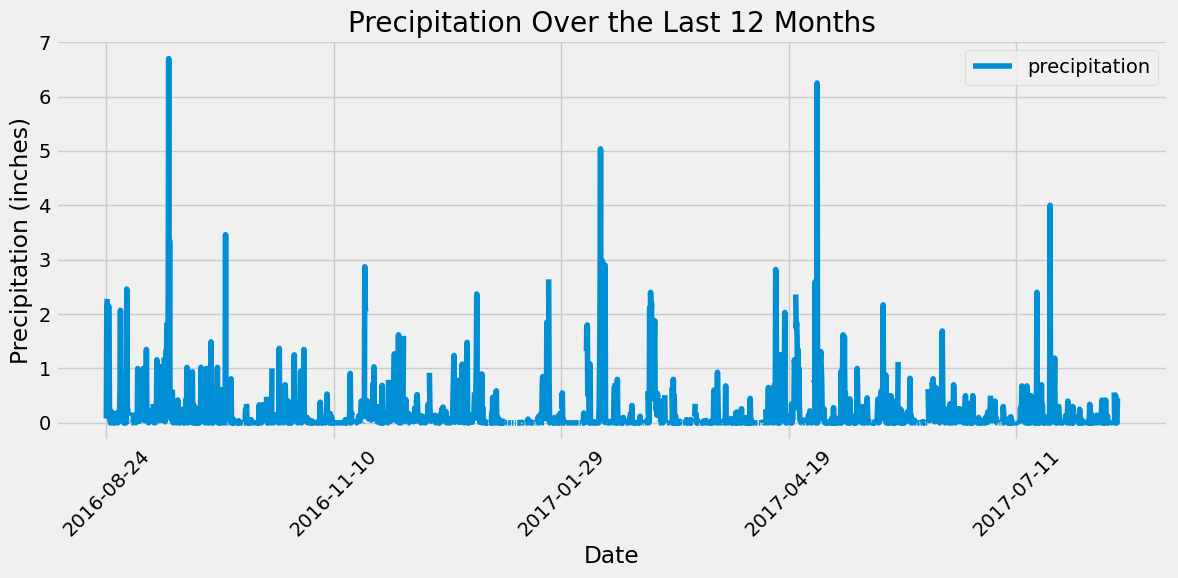

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
one_year_ago = datetime.datetime.strptime(most_recent_date, "%Y-%m-%d") - datetime.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= one_year_ago)
    .order_by(Measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=["date", "precipitation"])

# Sort the dataframe by date
precip_df = precip_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(x="date", y="precipitation", figsize=(12, 6))
plt.title("Precipitation Over the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = (
    session.query(Measurement.station, func.count(Measurement.id))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.id).desc())
    .all()
)

# Display the results
for station, count in station_activity:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = "USC00519281"

temp_stats = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    )
    .filter(Measurement.station == most_active_station)
    .one()
)

print(f"Lowest Temperature: {temp_stats[0]}")
print(f"Highest Temperature: {temp_stats[1]}")
print(f"Average Temperature: {temp_stats[2]:.2f}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


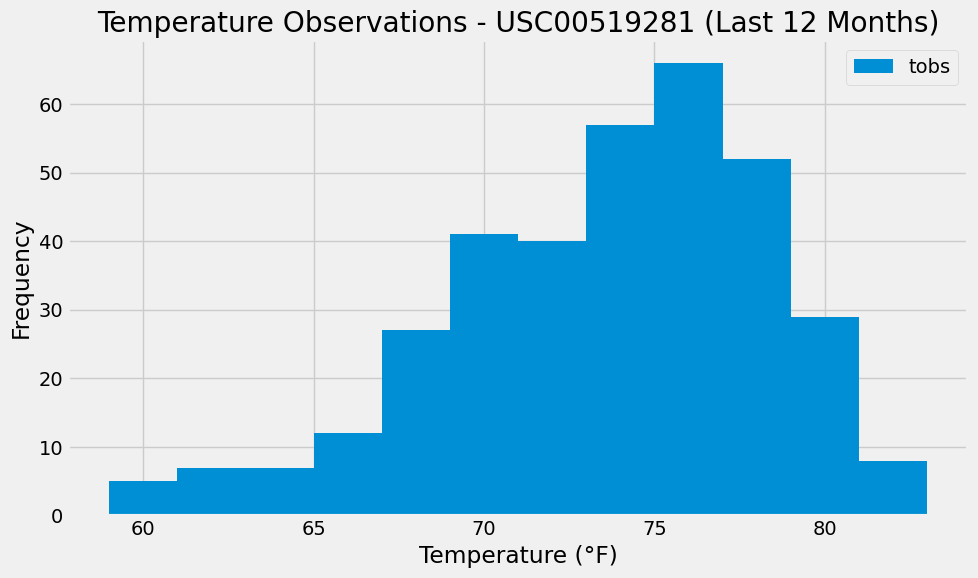

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query TOBS data for the last year from the most recent date
tobs_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

# Convert to DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=["tobs"])

# Plot the histogram
tobs_df.plot.hist(bins=12, figsize=(10, 6))
plt.title(f"Temperature Observations - {most_active_station} (Last 12 Months)")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close Session

In [18]:
# Close Session
session.close()
